In [1]:
import warnings
warnings.filterwarnings(action="ignore")


# Árboles de Decisión 

> __Alcance de la lectura__
>
> * Entender el proceso de búsqueda binaria en los Árboles de decisión.
> * Conocer los conceptos de nodo, hoja, pureza, ganancia y entropía en los árboles de decisión.
> * Implementar árboles de clasificación y regresión con `sklearn`.
> * Identificar los hiperparámetros asociados al ajuste de un árbol de decisión y su efecto.
> * Implementar búsqueda de hiperparámetros

## Motivación

Hasta el momento, los modelos y técnicas predictivas se han basado en procesos matemáticos relativamente complejos que son entendibles para la máquina, pero no para nosotros. Lo ideal sería encontrar un modelo que combine un buen desempeño predictivo, junto con una interpretación más humana de los datos que incorporamos. Ya tenemos conocimiento sobre el enfoque de la regresión para modelar problemas, haciéndola atractiva dado su capacidad de interpretación. Ahora conoceremos los __árboles de decisión__, una técnica substancialmente más entendible para el investigador.

Los árboles de decisión se asemejan a la forma en que los seres humanos toman decisiones. Básicamente aprenden una jerarquía de preguntas en formato `if/else` que conllevan a una decisión. Para ejemplificar el caso de uso, imaginemos que nos pasan una serie de datos sobre animales y nos piden clasificarlos acorde a si son mamíferos o no. Los datos entregados tienen la siguiente estructura:

In [3]:
import pandas as pd
import numpy as np
from IPython.display import Image
import lec7_graphs as afx

In [4]:
df = pd.read_csv('vertebrate.csv')
df.sample(5, random_state=11238)

,name,warm_blood,gives_birth,aquatic,aerial,has_legs,hibernates,class
8,cat,1,1,0,0,1,0,mammals
2,salmon,0,0,1,0,0,0,fishes
3,whale,1,1,1,0,0,0,mammals
1,python,0,0,0,0,0,1,reptiles
14,salamander,0,0,1,0,1,1,amphibians


Tenemos los siguientes atributos para cada animal: Si son de sangre caliente, si dan a luz, si son acuáticos o aereos, si tienen piernas e hibernan. El objetivo de un árbol de decisión es _identificar qué atributos facilitan la discriminación de nuestra respuesta_. Sabemos de antemano que las principales características de un mamífero son que den a luz y que tengan sangre caliente. Lo que buscamos es realizar una pregunta a cada atributo sobre cada observación, y posteriormente seguir realizando preguntas hasta que nuestras categorías. Mientras que para nosotros la discriminación de atributos es intuitiva y fácil de implementar, una máquina necesita más pasos.

Para un árbol de decisión, el proceso de discriminación de clases implica identificar qué atributos facilitan la discriminación y qué tan pura es la discriminación en cada fase. Tomemos como ejemplo la figura realizada con `afx.demo_classsification_tree`. Partimos con una pregunta inicial que se conoce como __nodo__, _¿Da a luz el animal?_. Con 15 observaciones observamos que hay 9 observaciones que no dan a luz y por tanto no son mamíferos. Cuando una pregunta llega a un punto de pureza (sólo existe una clase en su partición), no hay preguntas por realizar y el proceso para. Esta fase se conoce como __nodo terminal__ o __hoja__.

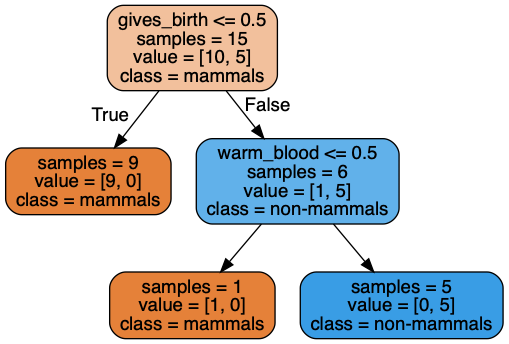

In [5]:
# recodificamos en mamiferos/no mamiferos
df['class'] = df['class'].replace(['fishes','birds','amphibians','reptiles'],'non-mammals')
# guardamos los nombres de las clases en un nuevo objeto 
store_y_labels = df['class'].unique()
# recodificamos de forma binaria
df['class'] = np.where(df['class'] == 'mammals', 1, 0)
# eliminamos atributos irrelevantes de la matriz de atributos
X_mat=df.drop(columns=['name', 'class'])
# Implementamos nuestra función y la guardamos en un nuevo objeto
dec_tree = afx.demo_classfication_tree(X_mat, df['class'], store_y_labels)
# renderizamos el objeto
Image(dec_tree.create_png())

En este caso, observamos que posterior a la pregunta sobre cómo da a luz el animal, la siguiente pregunta es si el animal es de sangre caliente o no. El objetivo de ésta pregunta es aumentar la pureza de la partición. Es en este nodo donde logramos identificar todos los mamíferos. Otro análogo al proceso es mediante el desarrollo de queries:

#### Query 1: ¿Da a luz?

* Separamos entre los grupos con respuesta positiva

In [6]:
question_1_pos = df.query('gives_birth == 1')

* Y el grupo con respuesta negativa

In [7]:
question_1_neg = df.query('gives_birth == 0')

* Investigamos la pureza de la clase. Para los animales que no dan a luz, no hay casos identificados como mamíferos. Por tanto no podemos seguir preguntando

In [8]:
question_1_neg['class'].value_counts()

0    9
Name: class, dtype: int64

* Investigamos la pureza de la clase para los casos negativos. Para los animales que si dan a luz, hay 1 que no es mamífero. Podemos seguir analizando este subconjunto.

In [9]:
question_1_pos['class'].value_counts()

1    5
0    1
Name: class, dtype: int64

#### Query 2: ¿Es de sangre caliente?

* En base al subgropo podemos separar entre los grupos con respuesta positiva.

In [10]:
question_2_pos = question_1_pos.query('warm_blood == 1')

* El grupo con respuesta negativa

In [11]:
question_2_neg = question_1_pos.query('warm_blood == 0')

* Investigamos la pureza de la clase. Para los animales con sangre caliente, todos los casos identificados son mamíferos y alcanzamos pureza

In [12]:
question_2_pos['class'].value_counts()

1    5
Name: class, dtype: int64

In [13]:
question_2_neg['class'].value_counts()

0    1
Name: class, dtype: int64

Lo que realizamos arriba se conoce como un proceso de búsqueda _greedy_: buscamos optimizar de forma local en base a la pregunta. Resulta que las máquinas toman en cuenta otros atributos y procesos para realizar una partición con pureza.

## Aspectos formales de los árboles de decisión

> La exposición formal sobre los árboles de decisión se basa en _Shalev-Shwartz, S y Ben-David, S. 2014. Understanding Machine Learning: From Theory to Algorithms. Capítulo 18: Decision Trees_, y Hastie, T; Tibshirani, R y Friedman, J. 2009. The Elements of Statistical Learning: Data Mining, Inference, and Prediction. Springer Series in Statistics. Springer. Ch9: Additive Models, Trees, and Related Methods. 9.2: Tree-Based Methods.

Los árboles de decisión son métodos con forma funcional $f(x): \mathcal{X}\rightarrow\mathcal{Y}$ que permiten predecir una clase asociada $y$ con una instancia específica $\mathbf{x}$ al recorrer desde un nodo principal hasta una hoja (o nodo terminal). El objetivo de los árboles de decisión es encontrar una serie de reglas de división del espacio muestral que __optimicen la decisión local__. En cada nodo se busca resolver la siguiente función

$$
\widehat{f}(x) = \sum_{m=1}^{s} c_{m}I \big((X_{1}, X_{2}) \in \mathbb{R}_{m}\big)
$$

Donde $\mathbb{R}_{m}$ es la región $m$ producto de la partición definido en el espacio de atributos $\mathbb{R}_{m}\ni (X_{1}, X_{2})$, $c_{m}$ es el promedio del vector objetivo en la región. El objetivo es dado una partición del espacio de atributos, encontrar un puntaje de corte (denominado $s$) que asigne una nueva observación a una de las dos regiones.

$$
\mathbb{R}_{1}(j, s) = \{X \vert X_{j} \leq s\} \quad \textsf{ó} \quad \mathbb{R}_{2}(j, s) = \{X \vert X_{j} \geq s\}
$$

Para encontrar el puntaje de corte $s$  en el espacio de atributos, es necesario optimizar por algún criterio. En este caso trabajaremos con un árbol de regresión donde el vector objetivo es contínuo.

$$
\underset{j,s}{\textsf{argmin}} \Big[\underset{c_{1}}{\textsf{argmin}}\sum_{x_{i} \in \mathbb{R}} (y_{i} - c_{1})^{2} + \underset{c_{2}}{\textsf{argmin}}\sum_{x_{i} \in \mathbb{R}} (y_{i} - c_{2})^{2}\Big]
$$

 donde $c_{1}$ y $c_{2}$ hacen referencia al promedio específico del vector objetivo en el espacio a dividir. 

$$
\widehat{c}_{1} = \textsf{promedio}\Big(y_{i} \big\vert X_{i} \in \mathbb{R}_{1}(j, s)\Big) \quad \textsf{y} \quad \widehat{c}_{2} = \textsf{promedio}\Big(y_{i} \big\vert X_{i} \in \mathbb{R}_{2}(j, s)\Big)
$$

El proceso se itera hasta que las particiones realizadas en cada espacio de atributos no sean informativas. Esto se conoce como __pureza__ de la partición. Para el caso de los árboles de regresión, el criterio para implementar es el _error cuadrático promedio_, que cuantifica la contribución en la reducción de la varianza de determinado atributo. Posteriormente trabajaremos con árboles de clasificación que implementan otros criterios de optimización.

### Aspectos adicionales a considerar en la implementación de árboles

Resulta que uno de los principales temas respecto a los árboles de decisión es estimar hasta qué punto es necesario hacerlos crecer. Uno de los principios básicos es que se priorizan árboles pequeños por sobre árboles grandes. Cada árbol con $n$ nodos se puede describir en $n+1$ bloques con tamaño $\textsf{log}_{2}(d + 3)$. Cada bloque indica los siguientes puntos del nodo:

- Un nodo interno de forma $I_{x_{i} < \theta}\  \forall i \in d$
- Una hoja con valor 1.
- Una hoja con valor 0.
- Fin del código

Esperamos un menor riesgo del modelo en entrenamiento en la medida que nuestros árboles son más complejos, a riesgo de incurrir en overfitting. En el otro lado necesitamos un árbol con un nivel justo que minimize el riesgo empírico de los datos. Dado que encontrar un óptimo puede ser  computacionalmente costoso, se prefiere implementa funciones heurísticas con un enfoque greedy, donde el árbol va incrementando de forma secuencial en función de la maximización de un óptimo local en la construcción de cada nodo. Uno de los problemas de éste enfoque es el hecho que no nos garantiza un óptimo global.

## Árboles de Regresión: Analizando los precios del mercado inmobiliario en California

Para ejemplificar cómo funcionan los árboles de decisión, utilizaremos una base de datos sobre precios de inmuebles en California. La fuente de los datos proviene de _Pace, K and Barry, R. 1997. Sparse Spatial Autoregressions. Statistics and Probability Letters. 33: 291-297_. El objetivo es generar predicciones del precio de los inmuebles en California, dado su posición geográfica (Longitud y Latitud), cantidad de piezas, el ingreso promedio de la zona, población, cantidad de casas y el año de la casa. Partamos por preparar nuestro ambiente de trabajo.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lec7_graphs as afx
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)
df = pd.read_csv('cadata.csv', header=1).drop(columns='1')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
MedianHouseValue    20640 non-null float64
MedianIncome        20640 non-null float64
MedianHouseAge      20640 non-null float64
TotalRooms          20640 non-null float64
TotalBedrooms       20640 non-null float64
Population          20640 non-null float64
Households          20640 non-null float64
Latitude            20640 non-null float64
Longitude           20640 non-null float64
dtypes: float64(9)
memory usage: 1.4 MB


Como siempre, un primer paso es ver cómo se comportan las variables. Para este ejemplo, todas las variable son numéricas y punto flotante, por lo que podremos realizar un gráfico de densidad.

In [16]:
df.describe()

,MedianHouseValue,MedianIncome,MedianHouseAge,TotalRooms,TotalBedrooms,Population,Households,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,206855.816909,3.870671,28.639486,2635.763081,537.898014,1425.476744,499.539680,35.631861,-119.569704
std,115395.615874,1.899822,12.585558,2181.615252,421.247906,1132.462122,382.329753,2.135952,2.003532
min,14999.000000,0.499900,1.000000,2.000000,1.000000,3.000000,1.000000,32.540000,-124.350000
25%,119600.000000,2.563400,18.000000,1447.750000,295.000000,787.000000,280.000000,33.930000,-121.800000
50%,179700.000000,3.534800,29.000000,2127.000000,435.000000,1166.000000,409.000000,34.260000,-118.490000
75%,264725.000000,4.743250,37.000000,3148.000000,647.000000,1725.000000,605.000000,37.710000,-118.010000
max,500001.000000,15.000100,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,41.950000,-114.310000


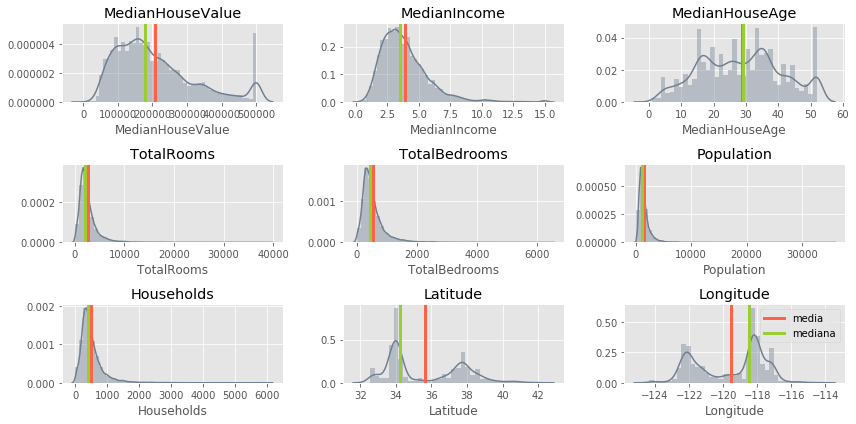

In [17]:
rows, cols = df.shape
cols = np.sqrt(cols)

plt.figure(figsize=(12, 6))
for index, (colname, serie) in enumerate(df.iteritems()):
    plt.subplot(cols, cols, index + 1)
    sns.distplot(serie, color='slategrey')
    plt.axvline(np.mean(serie), color='tomato', label = "media", lw=3)
    plt.axvline(np.median(serie), color='yellowgreen', label='mediana', lw=3)
    plt.title(colname)
plt.tight_layout()
plt.legend()

Mediante la inspección visual de los datos, nos percatamos que hay dos variables candidatas para transformarlas con logaritmo. La primera es nuestra variable objetivo _MedianHouseValue_ y la segunda es _MedianIncome_, la cual representa el ingreso mediano del sector donde se encuentra la casa.

Observamos que _Latitude_ y _Longitude_ presentan una distribución empírica con dos cúspides. Cabe destacar que mientras la latitud presenta una cúspide más pronunciada en los valores bajo la media, la longitud presenta una cúspide más pronunciada en los valores sobre la media.

Resulta que ambas nos permiten realizar un mapeo sobre cómo se distribuyen los precios del mercado inmobiliario en California. El gráfico demuestra que hay dos núcleos que concentran los mayores precios de inmuebles (con colores rojos más pronunciados). Estos corresponden al Bay Area (que incluyen ciudades como San Francisco, Palo Alto y San José), y a Los Ángeles.

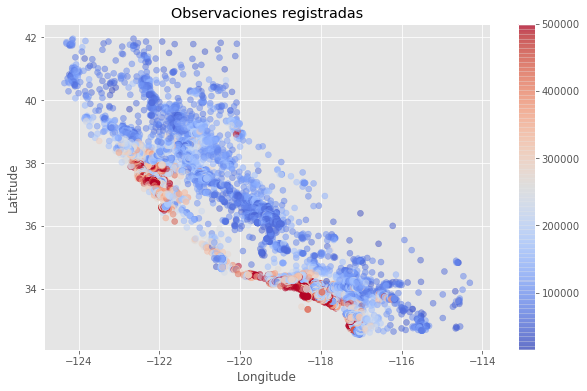

In [18]:
plt.scatter(df['Longitude'],
            df['Latitude'],
            c = df['MedianHouseValue'],
            cmap='coolwarm',
            alpha=.5)
plt.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Observaciones registradas');

### Nuestro primer árbol de regresión

Con nuestros datos inspeccionados, podemos comenzar a preparar nuestro análisis. Para montar nuestro primer modelo, simplemente incorporaremos todos atributos en el modelo. Debemos realizar los siguientes pasos:

1. Transformar los atributos _MedianHouseValue_ y _MedianIncome_ con el logaritmo.
- Eliminar los atributos repetidos en la matriz de atributos.
- Generar conjuntos de entrenamiento y validación.

In [19]:
from sklearn.model_selection import  train_test_split

# Vamos a trabajar con el logaritmo del vector para reducir no linealidad
df['log_MedianHouseValue'] = np.log(df['MedianHouseValue'])
# Sobreescribimos medianincome a log(medianincome)
df['log_MedianIncome'] = np.log(df['MedianIncome'])
# Definimos nuestro vector objetivo
y = df['log_MedianHouseValue']
# Definimos nuestra matriz de atributos y eliminamos irrelevantes
X = df.drop(columns=['MedianHouseValue', 'log_MedianHouseValue', 'MedianIncome'])
# Generamos muestras de entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=11238)

Para implementar nuestro árbol de regresión, necesitamos incorporar la clase `DecisionTreeRegressor` del módulo `tree` disponible en la librería `sklearn`. Como todo modelo de `sklearn`, los pasos para ejecutarlo son instanciar, ejecutar y contrastar el modelo siguiendo métricas. Dado que nuestro vector objetivo es contínuo, implementaremos las métricas más comunes como el error cuadrático promedio (`mean_squared_error`), la mediana del error absoluto (`median_absolute_error`), y el coeficiente de determinación (`r2_score`).

In [20]:
from sklearn.tree import DecisionTreeRegressor

# Implementamos nuestro modelo sin modificar hiperparametros
dec_tree = DecisionTreeRegressor().fit(X_train, y_train)

In [21]:
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score

print("Test MSE:", mean_squared_error(y_test, dec_tree.predict(X_test)).round(5))
print("Test MAE:", median_absolute_error(y_test, dec_tree.predict(X_test)).round(5))
print("Test R2:", r2_score(y_test, dec_tree.predict(X_test)).round(5))

Test MSE: 0.10576
Test MAE: 0.1544
Test R2: 0.6788


Con nuestro modelo ejecutado, comparamos las métricas. Tanto el error cuadrático promedio como la mediana del error absoluto sugieren que nuestro modelo erra en aproximadamente .10 puntos en la escala logarítmica de nuestro vector objetivo. El coeficiente de determinación sugiere que hay un 67% de variabilidad en nuestro vector objetivo en la muestra de validación que se explica por los parámetros entrenados en nuestra muestra de validación. Si bien el desempeño del modelo es relativamente aceptable, hay márgen substancial para mejoras. Como todo modelo de aprendizaje de máquinas, cuando queremos mejorar la capacidad predictiva, comenzamos a ajustar los hiperparámetros.

### Hiperparámetros en los árboles de decisión

Los hiperparámetros a modificar en los árboles de decisión están asociados con las siguientes preguntas:
- ¿Hasta qué punto puedo dejar crecer un árbol?
- ¿Cuántos datos son suficientes en cada nodo para particionar o declararlo terminal?
- ¿Cuántos atributos son suficientes para que mi árbol pueda capturar de buena manera el fenómeno?

Otro aspecto a considerar y que visitaremos posteriormente, es el hecho que éstos hiperparámetros son idénticos si estamos hablando de un problema de regresión o clasificación. Para visualizar las particiones en el espacio, restringiremos el ejercicio a los atributos Longitud y Latitud, dado que permiten mapear de forma directa la división de áreas de la región de California.



#### Máximo de profundidad

Ya sabemos que un árbol puede crecer de manera indefinida hasta que todos los nodos sea puros. Resulta que en este escenario es más que probable que terminemos con un modelo muy bien ajustado a los datos de entrenamiento, que falla en poder ser generalizado a nuevas instancias. Este problema de __overfitting__ se puede solucionar mediante la limitación de _qué tan profundo puede ser un árbol_.

En la implementación de `sklearn`, el hiperparámetro de profundidad de los nodos se controla con `'max_depth'`. Si bien no hay reglas específicas sobre  un rango de máxima profundidad, sabemos que debe partir en 1 dado que ésta es la partición mínima posible. El rango de término puede ir desde 10 hasta arriba. En la figura generada como `afx.train_test_over_params` evaluamos el error cuadrático promedio del modelo en las muestras de entrenamiento y validación. Hay un par de comportamientos a destacar:

- En la medida que la profundidad máxima se torna más permisiva, el error cuadrático promedio en la muestra de entrenamiento se acerca a cero. Esta es una situación de overfitting.
- La curva del modelo en el testing set se estanca cuando la profundidad máxima del árbol es aproximadamente igual a 10. Este parece ser un buen hiperparámetro a incorporar

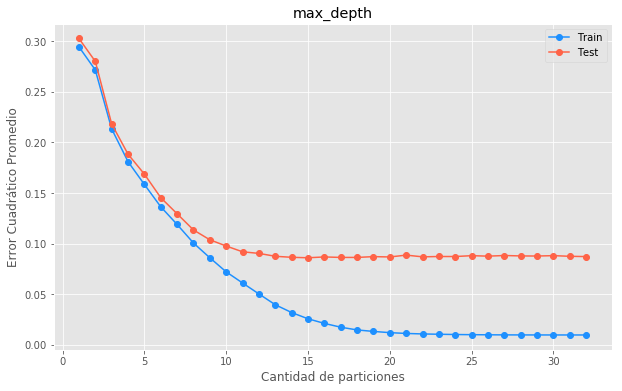

In [22]:
# generamos subconjuntos específicos para el problema de dos atributos
x_tr, x_te, y_tr, y_te = train_test_split(df.loc[:, ['Longitude', 'Latitude']],
                                          df['log_MedianHouseValue'],
                                          test_size=.33, random_state=11238)

# simulamos el desempeño en el rango del hiperparámetro
afx.train_test_over_params(DecisionTreeRegressor(),
                           {'max_depth': np.linspace(1, 32, 32)},
                           x_tr, x_te, y_tr, y_te)
plt.xlabel('Cantidad de particiones');
plt.ylabel('Error Cuadrático Promedio');

Ahora visualicemos cómo se comportan superficie de respuesta en la medida que aumentamos la profundidad del árbol. Cuando restringimos su profundidad a 1, se genera sólo 1 frontera de decisión, aproximadamente en la latitud 38. Inmuebles arriba de ésta latitud tendrán en promedio valores más bajos que los situados abajo de la latitud. Cuando la profundidad es evaluada en 10, nos permite recabar información. No toda observación situada ésta latitud es más cara. Hay un par de rectas en el cuadrante inferior izquierdo con un color rojo más fuerte, que son las zonas de San Francisco y Palo Alto, respectivamente.

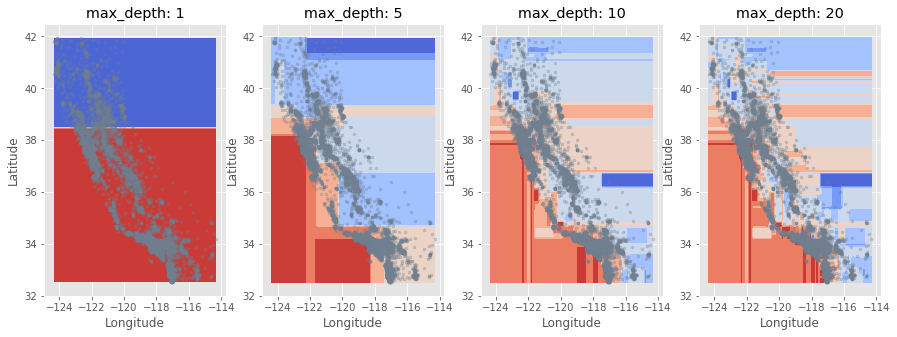

In [23]:
plt.figure(figsize=(15, 5))

# para cada valor predefinido del hiperparámetro
for index, value in enumerate([1, 5, 10, 20]):
    plt.subplot(1, 4, index + 1)
    # Implementamos un modelo con el ajuste específico
    tmp_model = DecisionTreeRegressor(max_depth=value)
    # Visualizamos la superficie de respuesta
    afx.plot_decision_function(tmp_model, df, 'Longitude', 'Latitude', 'log_MedianHouseValue',colorbar=False)
    plt.title("max_depth: {}".format(value))

#### Cantidad de atributos

El hiperparámetro `'max_features'` nos permite discriminar con cuántos atributos podemos alcanzar un buen desempeño del modelo. Recordemos que uno de los principios base de la modelación es la __parsimonía__: La capacidad de explicar de mejor manera con la menor cantidad de atributos posibles. Observamos que el efecto de la cantidad de atributos en la muestra de entrenamiento no afecta su desempeño, pero sí tiene un rol fundamental en la muestra de validación. Para este caso, los puntajes en el desempeño se estancan cuando consideramos entre 3 y 4 atributos.

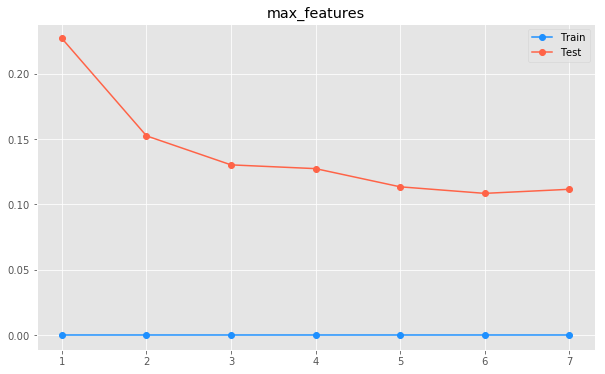

In [24]:
afx.train_test_over_params(DecisionTreeRegressor(),
                           {'max_features': list(range(1,X_train.shape[1]))},
                           X_train, X_test, y_train, y_test)

Uno de los puntos a favor de los modelos de árboles de decisión es que nos permite medir la importancia relativa de cada atributo en nuestro vector objetivo. Para obtener los puntajes de importancia relativa de un modelo, pueden acceder a ellos mediante `.feature_importances_` en el objeto instanciado, posterior al fit. De manera alternativa, puede ocupar la función `afx.plot_importance`. Se observa que _MedianIncome_, _Longitude_ y _Latitude_ son los atributos con una mayor importancia en predecir valores de nuestro vector objetivo. Podemos inferir que los precios están determinados de forma parcial por la ubicación y qué tan acaudalado es el sector, cosa que parece razonable.

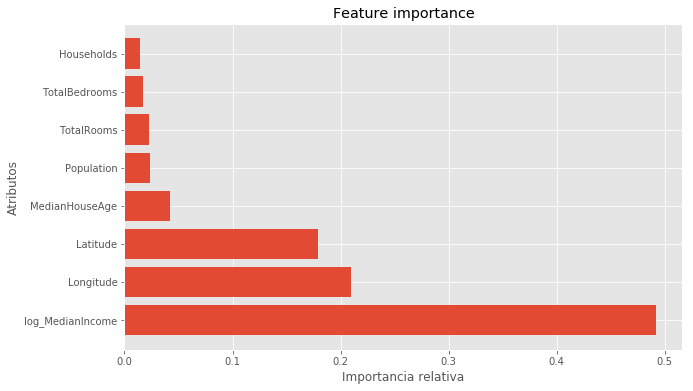

In [ ]:
afx.plot_importance(dec_tree, X.columns)
plt.xlabel("Importancia relativa");
plt.ylabel('Atributos');

#### Mínimo de muestras en un nodo particionable

Parte importante de nuestro árbol de decisión recae en los nodos. Mediante el mínimo de muestras en un nodo, respondemos cuándo podemos considerarlo como un nodo de decisión (donde podemos particionar) y cuando es un nodo terminal (no podemos particionar). En la medida que aumentamos la cantidad mínima de observaciones en el nodo, nuestro árbol se torna menos flexible. En situaciones donde se le pide una parte substancial de los casos, el modelo puede incurrir en alto sesgo y falta de acople en la partición de los datos. Esto conlleva a underfitting.

`sklearn` asume que el hiperparámetro considera el porcentaje específico del número de muestras. En el gráfico se aprecia que en la medida que nuestro modelo necesita de un mayor porcentaje de datos para poder considerar un nodo como válido para particionar, el error cuadrático promedio aumenta. En esta situación, el gráfico nos informa que ambas curvas tienen un comportamiento similar, y por tanto hay que elegir el hiperparámetro que disminuya el error en ambas.

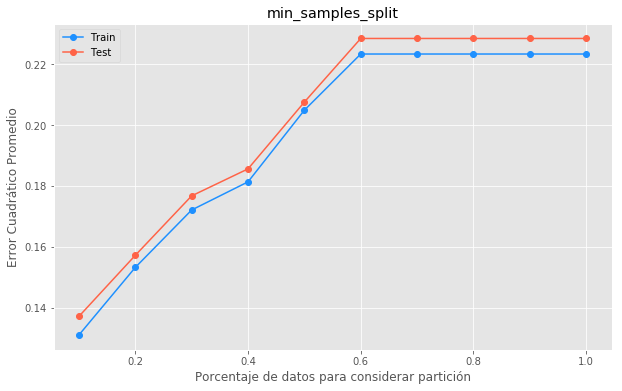

In [ ]:
afx.train_test_over_params(DecisionTreeRegressor(),
                           {'min_samples_split': np.linspace(0.1, 1.0, 10, endpoint=True)},
                           X_train, X_test, y_train, y_test)
plt.xlabel('Porcentaje de datos para considerar partición')
plt.ylabel('Error Cuadrático Promedio');

Para aclarar el comportamiento del mínimo de datos para considerar una partición, visualicemos la superficie de respuesta. En un extremo, cuando tenemos valores bajos, la superficie de respuesta tiende a ser mucho más consciente del rango de valores. En el extremo opuesto, cuando ésta se vuelve alta, nuestra capacidad de particionar nodos disminuye, generando una menor cantidad de divisiones.

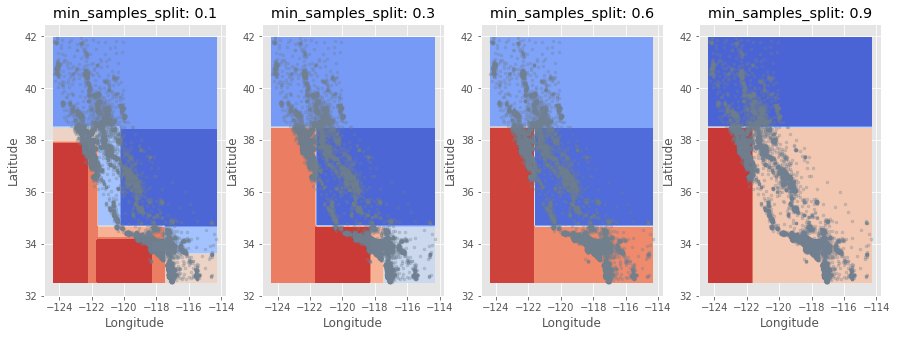

In [ ]:
plt.figure(figsize=(15, 5))
for index, value in enumerate([0.1, 0.3,0.6, 0.9]):
    plt.subplot(1, 4, index + 1)
    tmp_model = DecisionTreeRegressor(min_samples_split=value)
    afx.plot_decision_function(tmp_model, df, 'Longitude', 'Latitude', 'log_MedianHouseValue',colorbar=False)
    plt.title("min_samples_split: {}".format(value))

#### Mínimo de muestras en un nodo terminal

Mediante el mínimo de muestras en un nodo terminal, definimos cuándo el proceso de búsqueda termina en un nodo. Cuando los valores son bajos, significa que el modelo necesitará un menor porcentaje de los datos para poder crecer, aumentando su rango de acción. 

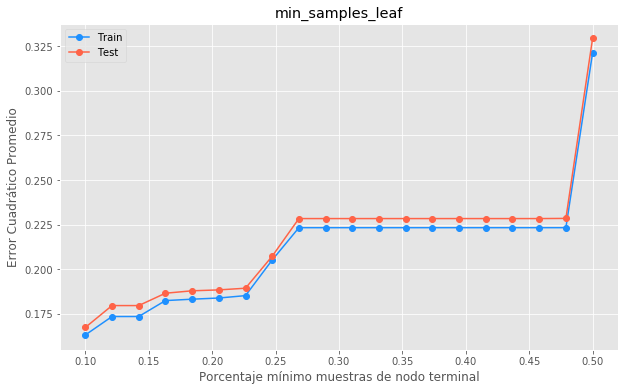

In [ ]:
afx.train_test_over_params(DecisionTreeRegressor(),
                           {'min_samples_leaf': np.linspace(0.1, 0.5, 20, endpoint=True)},
                           X_train, X_test, y_train, y_test)
plt.xlabel('Porcentaje mínimo muestras de nodo terminal')
plt.ylabel('Error Cuadrático Promedio');

De manera similar a `min_samples_split`, en la medida que aumentamos el valor de éste hiperparámetro lo tornamos más estricto, conllevando a underfitting.

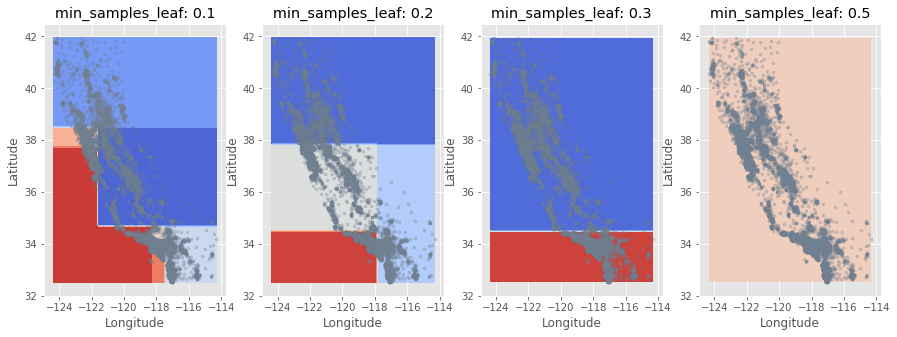

In [ ]:
plt.figure(figsize=(15, 5))
for index, value in enumerate([0.1,.20, .3, 0.5]):
    plt.subplot(1, 4, index + 1)
    tmp_model = DecisionTreeRegressor(min_samples_leaf=value)
    afx.plot_decision_function(tmp_model, df, 'Longitude', 'Latitude', 'log_MedianHouseValue',colorbar=False)
    plt.title("min_samples_leaf: {}".format(value))

## Árboles de Clasificación: Identificando la probabilidad de votar en un Plebiscito



Para exponer sobre los árboles de clasificación vamos a trabajar con una encuesta sobre votación en un Plebiscito a favor o en contra de una ley. Los atributos a considerar son la región del encuestado, la población de la ciudad donde vive el encuestado, el sexo del encuestado, la edad, el nivel educacional, su ingreso, si apoya o no al régimen y su votación en el Plebiscito.

En los casos que nuestro vector objetivo sea categórico, el procedimiento de partición se mantiene igual y sólo hay que cambiar el criterio de optimización de particiones. En los árboles de regresión implementábamos una medida basada en el error cuadrático promedio __en la partición__, lo cual no es válido en los casos de clasificación. 



$$
\textsf{Entropia (o Desviacion)}= -\sum_{k=1}^{K}\hat{p}_{mk}\textsf{log}\hat{p}_{mk}
$$

$$
\textsf{Gini} = \sum_{k \neq k'}\hat{p}_{mk}\hat{p}_{mk'} = \sum_{k=1}^{K}\hat{p}_{mk}(1 - \hat{p}_{mk})
$$

$$
\textsf{Error de clasificacion} = \frac{1}{N_{m}}\sum_{i \in \mathbb{R}_{m}} I(y_{i} \neq k(m)) = 1 - \hat{p}_{mk(m)}
$$


Tanto la entropía como el índice de Gini son más sensibles a los cambios en la probabilidad de clases en el nodo que la tasa de clasificaciones erróneas. Es por este punto que se prefiere implementar cualquiera de las dos por sobre la tasa de clasificaciones erróneas. Resulta que la implementación en `sklearn` incluye estas dos, ignorando la tasa de clasificaciones erróneas.

Entre estas dos candidatas, el índice de Gini es preferible dado que presenta una mayor interpretabilidad que la Entropía. Hastie et al. (2009) sugieren que existen dos interpretaciones. Más que estar fijándose en la clasificación de observaciones en la clase mayoritaria (como lo realiza la tasa de error de clasificación), podemos fijarnos en la clasificación en una clase específica con probabilidad $\hat{p}_{mk}$. Otra forma de entender el índice de Gini es la razón entre clases. Cuando éste está cercano a .5, significa que existe una equiprobabilidad entre todas las clases de ocurrir en el nodo. Este sería un nodo impuro.

Grus (2012) sugiere que nuestro objetivo es encontrar atributos que entregen mayores niveles de información sobre lo que nuestro árbol debería predecir. Para obtener esta medición sobre qué tanta información se obtiene mediante la _entropía_. Para la ciencia de datos, la entropía tiene que ver con el grado de incertidumbre en los datos. Si tenemos un conjunto de datos $S$ donde cada observación se etiqueta con un número $C$ de clases. Si todos los datos pertenecen a alguna de las clases, no existe incertidumbre, lo que conlleva a una entropía baja. Viceversa cuando las clases están igualmente repartidas. Buscamos que la entropía sea lo más alta posible, situación que se logra cuando ésta es cercana a .5.


![](img/esl_gini_entropy.png)
_Hastie et al. (2009, 309)._

### Implementando un árbol de clasificación

De similar manera, la implementación de un árbol de clasificación se realiza mediante la incorporación de la clase `sklearn.tree.DecisionTreeClasifier`. Como se señalo anteriormente, los hiperparámetros a evaluar en el ajuste del modelo son exactamente los mismos que en `sklearn.tree.DecisionTreeRegression`. Lo único que varía es el criterio de partición. Mientras que en caso del árbol de regresión se evalúa mediante la reducción del error cuadrático, en los árboles de clasificación implementamos alguna de las métricas mencionadas anteriormente.

Partamos por incorporar la base de datos `voting.csv` y solicitar una observación al azar. Esta ob

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Importamos la base de datos
df = pd.read_csv('voting.csv').drop(columns='Unnamed: 0')
df.sample(1, random_state=11238)

,region,population,sex,age,education,income,statusquo,vote
206,N,3750,M,21.0,P,15000.0,-0.04558,N


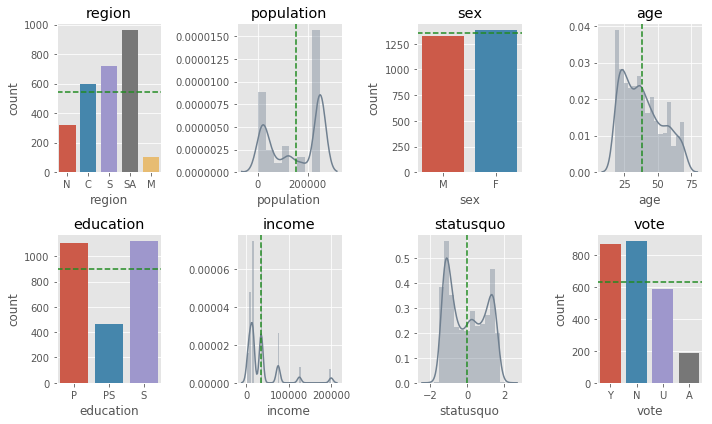

In [ ]:
rows = 2
cols = df.shape[1] // rows
for index, (colnames, serie) in enumerate(df.iteritems()):
    plt.subplot(rows, cols, index + 1)
    if serie.dtype == 'object':
        sns.countplot(serie.dropna())
        plt.axhline(serie.value_counts().mean(), color='forestgreen', linestyle='--')
        plt.title(colnames)
    else:
        sns.distplot(serie.dropna(), color='slategrey')
        plt.axvline(serie.mean(), color='forestgreen', linestyle='--')
        plt.title(colnames)
        
plt.tight_layout()

Se observa que en promedio los individuos en la muestra provienen de la región 'SA', el rango entre hombres y mujeres es relativamente similar. La edad de éstos se situá en promedio en los 40, con una mayor representación de individuos jóvenes. El nivel educacional varía substancialmente entre Primario y Secundario. El statusquo indica que el apoyo al régimen está polarizado entre aquellos que no lo aprueba (con valores negativos), y aquellos que si.

Posterior a importar la base de datos, generaremos una serie de variables por cada categoría de `region`, `sex`, `education` y nuestro vector objetivo: `vote`. Para ello implementaremos la función `pd.get_dummies`. Para evitar problemas de multicolinealidad en los modelos, eliminaremos las variables originales.

In [ ]:
# Vamos a binarizar cada variable categórica, ignorando la primera categoría de referencia
# Región del país
df = pd.concat([df, pd.get_dummies(df['region'], drop_first=True, prefix='region')], axis=1)
# Nivel educacional del encuestado
df = pd.concat([df, pd.get_dummies(df['education'], drop_first=True, prefix='ed')], axis=1)
# Sexo del encuestado
df = pd.concat([df, pd.get_dummies(df['sex'], drop_first=True, prefix='sex')], axis=1)
# Intención de voto
df = pd.concat([df, pd.get_dummies(df['vote'], drop_first=False, prefix='vote')], axis=1)
# Botamos las variables originales
df = df.drop(columns=['region', 'sex', 'education', 'vote'])
df.head()

,population,age,income,statusquo,region_M,region_N,region_S,region_SA,ed_PS,ed_S,sex_M,vote_A,vote_N,vote_U,vote_Y
0,175000,65.0,35000.0,1.00820,0,1,0,0,0,0,1,0,0,0,1
1,175000,29.0,7500.0,-1.29617,0,1,0,0,1,0,1,0,1,0,0
2,175000,38.0,15000.0,1.23072,0,1,0,0,0,0,0,0,0,0,1
3,175000,49.0,35000.0,-1.03163,0,1,0,0,0,0,0,0,1,0,0
4,175000,23.0,35000.0,-1.10496,0,1,0,0,0,1,0,0,1,0,0


Para efectos prácticos del ejercicio, nuestro objetivo es realizar un árbol de clasificacion que modele las chances que un individuo vaya a votar No. Lo que necesitamos es generar los conjuntos de entrenamiento y validación para posteriormente entrenar nuestro modelo, definiendo la matriz de atributos y el vector objetivo.

In [ ]:
# Nos aseguramos de limpiar los datos perdidos
df = df.dropna()

# generamos las muestras definiendo la matriz de atributos
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, 'population':'sex_M'],
                                                    # el vector objetivo
                                                    df['vote_N'],
                                                    # el tamaño de la muestra a dejar como validación
                                                    test_size=.33,
                                                    # definiendo la semilla pseudoaleatoria
                                                    random_state=11238)

Para este modelo, implementaremos una búsqueda de grilla con los cuatro hiperparámetros anteriormente explicados. El número de modelos estimables es $10 \times 32 \times 10 \times 11 \times 5 \times 2 = 352.000$, por lo que puede ser computacionalmente demandante. El tiempo de ejecución fue de 4 minutos y 30 segundos.

In [ ]:
# importamos la clase GridSearchCV
from sklearn.model_selection import GridSearchCV

In [ ]:
%%time
dec_tree_grid_cv = GridSearchCV(DecisionTreeClassifier(),
                                    # evaluamos 10 escenarios
                                   {'min_samples_split': np.linspace(0.1, 1.0, 10),
                                    # implementando 2 criterios de partición
                                    'criterion': ['gini', 'entropy'],
                                    # con una profundidad de ramas hasta 32
                                   'max_depth': np.linspace(1, 32, 32),
                                    # evaluando 10 escenarios
                                   'min_samples_leaf': np.linspace(0.1, 0.5, 10),
                                    # evaluando todos los atributos en la matriz
                                   'max_features': list(range(1,X_train.shape[1]))},
                                # Con 5 validaciones cruzadas
                                cv=5,
                                # Ocupando todos los núcleos del computador
                                n_jobs=-1).fit(X_train, y_train)

Al solicitar la mejor combinación de hiperparámetros, `GridSearchCV` nos informa que el máximo de profundidad necesaria de los nodos es de 23, implementando un criterio de partición basado en el índice de Gini, con un máximo de 5 atributos informativos, y con una norma para definir los nodos como terminales o particionables relativamente baja.

In [ ]:
dec_tree_grid_cv.best_params_

El desempeño __en la muestra de entrenamiento es 83%__, lo que indica que el modelo clasificó correctamente aproximadamente el 83% de las observaciones

In [ ]:
dec_tree_grid_cv.best_score_

El hiperparámetro `max_features` nos indica en este caso que el atributo `statusquo` concentra la mayor importancia relativa, seguida de `income` y `age`. Se supone que el modelo informa sobre 5 características, pero sólo 3 presentan importancia susbtancialmente distinta de cero.

In [ ]:
dec_tree_grid_cv.best_estimator_.feature_importances_

In [ ]:
colnames = df.loc[:, 'population':'sex_M'].columns
afx.plot_importance(dec_tree_grid_cv.best_estimator_, colnames)

### Evaluando el desempeño de un árbol de clasificación 

Realicemos la evaluación del modelo en el _held-out_, para revisar el desempeño en datos que no han sido entrenados previamente. Si importamos el método `classification_report` para extraer las métricas de evaluación en modelos de clasificación, obtendremos lo siguiente:

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test,
                            dec_tree_grid_cv.best_estimator_.predict(X_test)))

A grandes rasgos observamos que el modelo disminuyó su capacidad predictiva en 2%. Si bien esto no es un problema substancial, hay que optar a un desempeño igual o mejor al del training set. El detalle indica que el modelo tiene un mejor desempeño en clasificar las observaciones etiquetadas como 0 en comparación a aquellas identificadas como 1. 

## Aspectos adicionales

A continuación se señalan algunos aspectos adicionales a considerar al momento de implementar árboles de clasificación.

### Atributos categóricos con $k>2$

Por defecto, cuando trabajamos con un atributo con $k>2$ categorías no ordenadas, existen $2^{k - 1} - 1$ posibles divisores que permitan generar subespacios. Este proceso tiene un costo computacional prohibitivo cuando $k$ es muy grande.
La exposición previa de los métodos de árbol se realizó en consdieración a que los atributos son binarios o contínuos. Resulta que con los atributos categóricos $k > 2$ la división no es directa, por lo que se sugiere binarizar cada categoría. Esta estrategia la implementamos en el caso del árbol de clasificación.


### Valores perdidos en los atributos

Para atributos categóricos, podemos generar una categoría nueva para señalar los casos perdidos en ese atributo. Estos se conocen como __predictores surrogados__. Por defecto CART ignora los valores perdidos para medir la ganancia de una división. Para el caso cuando asignamos observaciones perdidas a uno de los dos lados de la división, CART implementa surrogados. Estos calculan a qué nivel otra serie de divisores candidatos producen resultados similares. Posteriormente la observación perdida se clasifica implementando el surrogado que más se parezca a la divisieon original.

### Divisiones en la combinación lineal de parámetros

Podemos superar el criterio de división de la forma $X_{j} \leq s$ a uno que permita realziar divisiones en la combinación lineal de parámetros de la forma $\sum \beta_{j}X_{j} \leq s$. En este escenario, los pesos $\beta_{j}$ y divisores $s$ se optimizan en función de criterio relevante. El trueque en este caso es entre un modelo con un mejor desempeño a riesgo de hacerlo menos intepretable.

### Inestabilidad de los árboles

Otro de los problemas frecuentes es la alta varianza existente en los modelos de árboles. Dado que la optimizacion de las divisiones depende fuertemente de los datos de entrenamiento, la modificación parcial de una observación puede conllevar a pérdidas substanciales en la similitud del modelo. Esto se debe a que el proceso es estrictamente jerárquico, donde los errores en nodos superiores se propagan por las ramas.

### Falta de suavidad en la función

Este es un problema común en los árboles de regresión, donde el vector objetivo tiene una mejor caracterízación en su superficie de respuesta mediante la combinación lineal de parámetros. Al implementar divisiones en los atributos, omitimos de forma deliberada parte de la varianza de los atributos, conllevando a una interpretación secuencial y anidada por sobre la interpretación de la forma funcional lineal.

### CART no es la única solución

Un aspecto a considerar es que la exposición sobre los árboles presentada corresponde a un marco analítico llamado CART (_Classification And Regression Tree_), ideado por Breiman et al. (1984). Ésta solución no es la única, pero es la que tiene un mayor consenso como dominante. Existen variantes como el _ID3_ y el _Cubist (4.5/5.0)_ que tienen implementaciones separadas (Ver Quinlan, 1986, 1993). Lamentablemente no componen parte de la suite base de `sklearn`.



# Referencias

* Murphy, K. 2012. Machine Learning. A Probabilistic Perspective. Cambridge: MA. Massachussets Institute of Technology Press.
* Breiman, L.; Friedman, J.H.; Olshen, R.A.; and Stone, C.I. 1984. Classification and regression trees. Belmont, California: Wadsworth Press.
* Hastie, T; Tibshirani, R, Friedman, J.H. 2009. The Elements of Statistical Learning. Data Mining, Inference and Prediction. New York City: NY. Springer.
* Shalev-Shwartz, S y Ben-David, S. 2014. Understanding Machine Learning: From Theory to Algorithms. Capítulo 18: Decision Trees
* Grus, J. 2014. Data Science from Scratch. O'Reilly.